# TFRecord Test

I have never worked with protocol buffers or TFRecord files before, and I'd like to confirm that these have been properly encoded before I start running the training job. I'm going to read a few back in and visualize them.

I also will need to encode the test image set to TFRecord images for inference. 

In [17]:
import pandas as pd
import numpy as np
import glob
import os
import cv2
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from tqdm.notebook import tqdm

import tensorflow as tf

In [2]:
INPUT_PATH = "./global-wheat-detection"

validation_set = tf.data.TFRecordDataset(os.path.join(INPUT_PATH, "validation.tfrecord"))

I'm going to check 10 images from the validation set. 

In [3]:
sample_examples, i = [], 0

for example in validation_set:
    
    if i > 9:
        
        break
    
    sample_examples.append(example)
    
    i += 1

In [4]:
## utility function for opening and plotting image data (hopefully)
## going to write it so that you can only plot two images at a time, 
## otherwise you won't be able to see the boundary boxes accurately
## I'm going to write in a similar style to the one I wrote in the EDA
## notebook... might not be the most space efficient way but at least 
## I know it works

def plot_examples(examples: list, img_height: int, img_width: int):
    
    def rescale(x, scalar):
        
        return(int(x * scalar))
    
    if len(examples) != 2:
        
        raise ValueError("Only accepts list of two tensors, idiot")
        
    img_data = []
    
    for i, example in enumerate(examples):
        
        parsed_img = tf.train.Example.FromString(examples.numpy())
        
        encoded = parsed_img.features.feature['image/encoded'].bytes_list.value[0]
        
        xmin = parsed_img.features.feature['image/object/bbox/xmin'].float_list.value[:]
        
        xmax = parsed_img.features.feature['image/object/bbox/xmax'].float_list.value[:]
        
        ymin = parsed_img.features.feature['image/object/bbox/ymin'].float_list.value[:]
        
        ymax = parsed_img.features.feature['image/object/bbox/ymax'].float_list.value[:]
        
        for k in range(len(xmin)):
            
            d = {}
            
            d["encoded_img"] = encoded
            
            d["xmin"] = xmin[k]
            
            d["xmax"] = xmax[k]
            
            d["ymin"] = ymin[k]
            
            d["ymax"] = ymax[k]
            
            img_data.append(d)
            
    img_df = pd.DataFrame(img_data)
    
    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    
    for i, encoded_file in enumerate(img_df.encoded_img.unique()):
        
        partial = img_df[img_df.encoded_img == encoded_file].reset_index(drop = True)
        
        partial["xmin"] = partial["xmin"].apply(lambda x: rescale(x, img_width))
        
        partial["xmax"] = partial["xmax"].apply(lambda x: rescale(x, img_width))
        
        partial["ymin"] = partial["ymin"].apply(lambda x: rescale(x, img_height))
        
        partial["ymax"] = partial["ymax"].apply(lambda x: rescale(x, img_height))
        
        img = Image.open(BytesIO(encoded_file))
        
        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        
        for _, row in partial.iterrows():
        
            cv2.rectangle(img_cv, (row.xmin, row.ymin), (row.xmax, row.ymax), (255, 0, 0), 2)
            
        ax[i].set_axis_off()

        ax[i].imshow(img_cv)

        ax[i].set_title(f"Sample Image {i}")

That should do it. Let's take a look at a few of these images

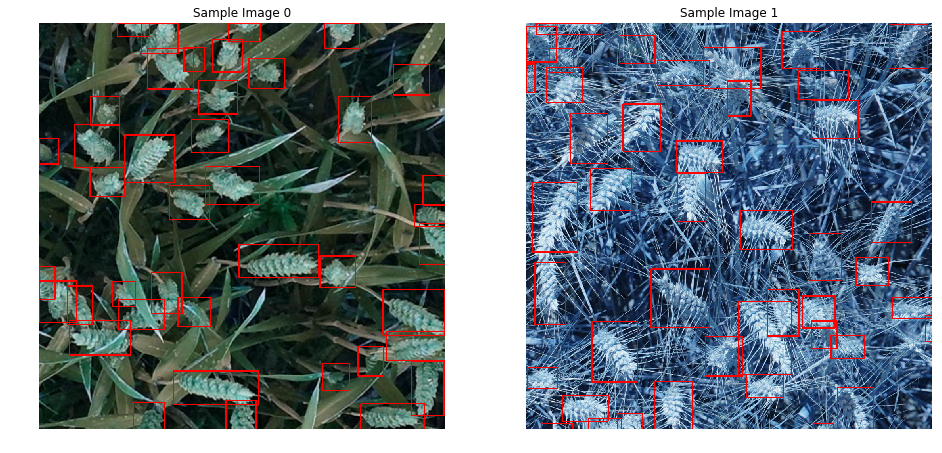

In [5]:
plot_examples(sample_examples[:2], 1024, 1024)

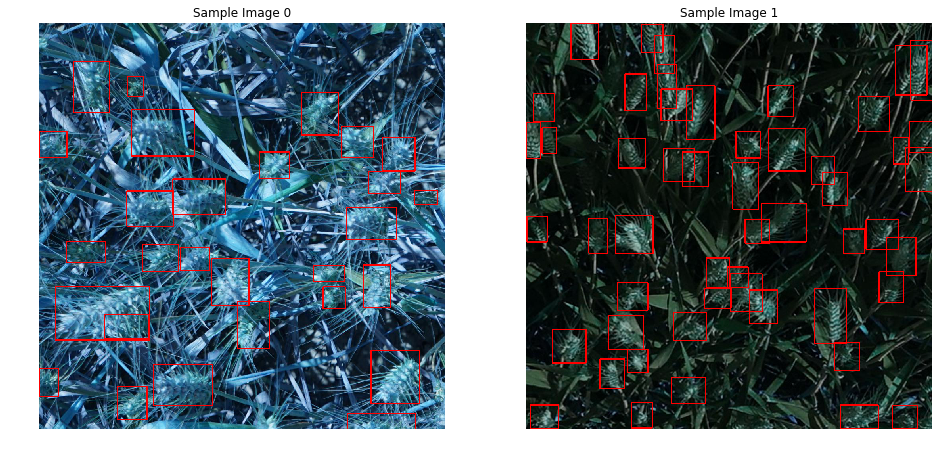

In [6]:
plot_examples(sample_examples[2:4], 1024, 1024)

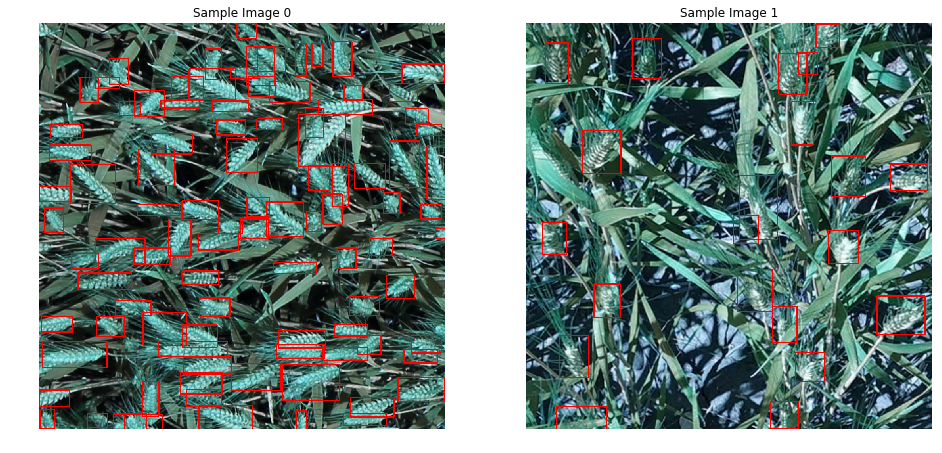

In [7]:
plot_examples(sample_examples[4:6], 1024, 1024)

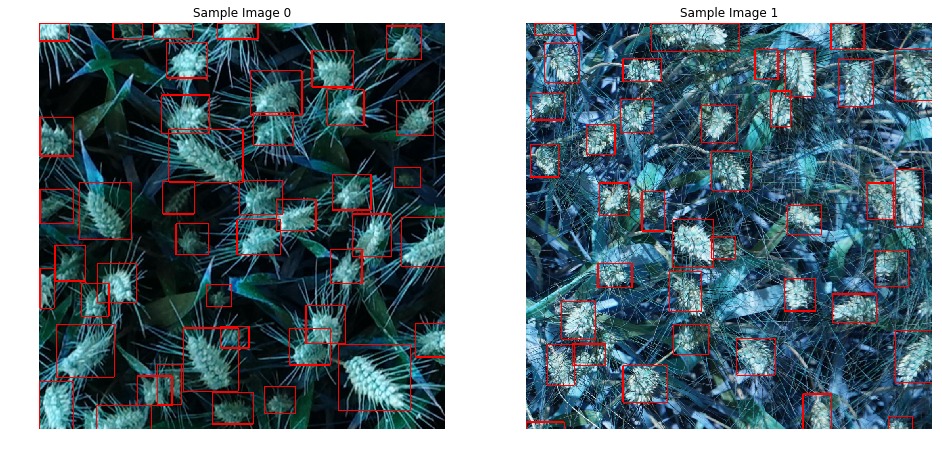

In [8]:
plot_examples(sample_examples[6:8], 1024, 1024)

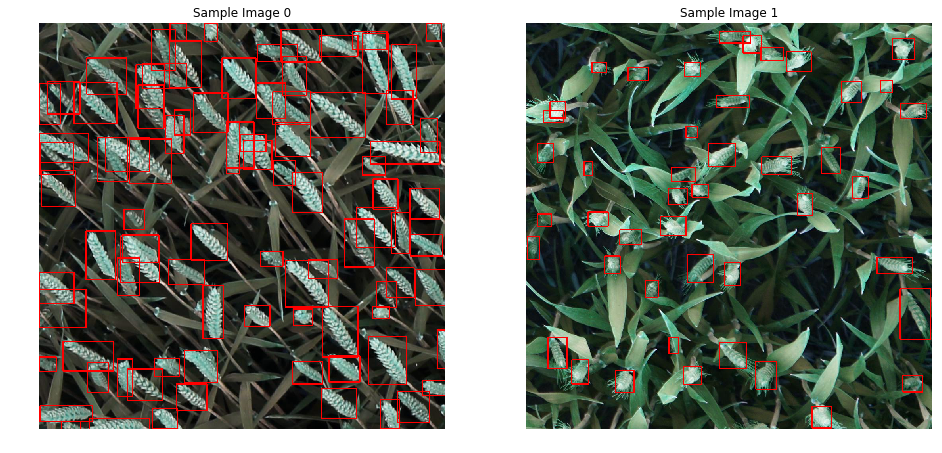

In [9]:
plot_examples(sample_examples[8:10], 1024, 1024)

Excellent, the encoding appears to be working properly. This function will be useful later in the inference notebook for plotting predicted boxes. Now I'm going to run some data checks on the records.

In [20]:
def validate_dataset(filenames, reader_opts=None):
    """
    Attempt to iterate over every record in the supplied iterable of TFRecord filenames
    :param filenames: iterable of filenames to read
    :param reader_opts: (optional) tf.python_io.TFRecordOptions to use when constructing the record iterator
    """
    i = 0
    
    for fname in filenames:
        
        print('validating ', fname)

        record_iterator = tf.compat.v1.io.tf_record_iterator(path=fname, options=reader_opts)
        
        try:
            
            for _ in record_iterator:
                
                i += 1
                
        except Exception as e:
            
            print('error in {} at record {}'.format(fname, i))
            
            print(e)

In [16]:
validate_dataset(["./global-wheat-detection/validation.tfrecord", "./global-wheat-detection/train.tfrecord"])

validating  ./global-wheat-detection/validation.tfrecord
validating  ./global-wheat-detection/train.tfrecord


# Encoding Test Images
The test images, of which I only have a handful as Kaggle has hidden the rest, need to be encoded to use the __infer_detection__ script. While there are other ways to use the trained model for inference, this is the preferred way because it will perform the image preprocessing necessary for the model.

In [3]:
test_imgs = glob.glob("./global-wheat-detection/test/*.jpg")

print(f"There are {len(test_imgs)} images in the test directory")

There are 10 images in the test directory


In [16]:
## This is a utility function to write test images to file. It is different than the training dataset script
## because in this case the inputs are images, not a pd.DataFrame
def write_record(file):
        
    with tf.io.gfile.GFile(file, "rb") as f:

        encoded = f.read()

    encoded_io = BytesIO(encoded)

    with Image.open(encoded_io) as img:

        width, height = img.size

    img_format = b"jpeg"

    filename = file.split("/")[-1].encode()

    source = file.split("/")[-1].split(".")[0].encode()

    tf_record = tf.train.Example(features = tf.train.Features(feature = {

        "image/height" : tf.train.Feature(int64_list = tf.train.Int64List(value = [height])),

        "image/width" : tf.train.Feature(int64_list = tf.train.Int64List(value = [width])),

        "image/filename" : tf.train.Feature(bytes_list = tf.train.BytesList(value = [filename])),

        "image/source" : tf.train.Feature(bytes_list = tf.train.BytesList(value = [source])),

        "image/encoded" : tf.train.Feature(bytes_list = tf.train.BytesList(value = [encoded])),

        "image/format" : tf.train.Feature(bytes_list = tf.train.BytesList(value = [img_format])),

    }))

    return(tf_record)

In [18]:
with tf.io.TFRecordWriter("./global-wheat-detection/test_images.tfrecord") as writer:
                    
    for file in tqdm(test_imgs):

        tf_record = write_record(file)

        writer.write(tf_record.SerializeToString())

In [21]:
validate_dataset(["./global-wheat-detection/test_images.tfrecord"])

validating  ./global-wheat-detection/test_images.tfrecord
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


With the images converted, now it is time to inference.